### Instructions
The notebook presents the execution of KONG for the Dunnhumby and MovieLens datasets.

The _MovieLens dataset_ consists of movie ratings given by users. Selecting a given user, we connect it wo all movies s/he has rated, thus we build a bipartite graph. Movies are labeled by one of 19 genres and users by their quantized age. We create graphs by traversing the 2-hop neighborhood for each user, i.e., each graph is rooted at a given user. The class of the graph is the user's gender.

The _Dunnhumby dataset_ represents customers and purchased products. Customers are labeled by their affluence and products to one of the 9 categories they belong to. Similarly to MovieLens, we create a graph starting from each user and traversing its 2-hop neighborhood. The class of each graph is the customer's lifestage which is a combination of age and gender. 

Before running the code please do the following steps: 
* Download 10 files with random numbers from [here](https://web.archive.org/web/20160119150146/http://stat.fsu.edu/pub/diehard/cdrom/) and store them into the folder **random** (if there is no such folder, create it).
* For the MovieLens experiments download the MovieLens files from [here](http://files.grouplens.org/datasets/movielens/ml-1m.zip) and decompress it into the folder **data**.
* Make sure the folder **graphs** is empty.


In [1]:
#we first create graphs from the Dunnhumby/MovieLens dataset
import read_dunnhumby
import movielens_to_graph

In [2]:
#make sure the path is correct 
dataset = 'data/dunnhumby/merged.csv'

#this is the directory where we write the generated graphs, if not existent, create it
graph_folder = 'graphs/'

In [3]:
#convert the dataset to graphs
read_dunnhumby.to_graphs(dataset, graph_folder)

#For the MovieLens dataset
#the last argument is the number of graphs we want to generate
#nr_graphs = 1000
#movielens_to_graph.create_graphs(E, users, items, graph_folder, nr_graphs)

Index(['SHOP_WEEK', 'SHOP_DATE', 'SHOP_WEEKDAY', 'SHOP_HOUR', 'QUANTITY',
       'SPEND', 'PROD_CODE', 'PROD_CODE_10', 'PROD_CODE_20', 'PROD_CODE_30',
       'PROD_CODE_40', 'CUST_CODE', 'CUST_PRICE_SENSITIVITY', 'CUST_LIFESTAGE',
       'BASKET_ID', 'BASKET_SIZE', 'BASKET_PRICE_SENSITIVITY', 'BASKET_TYPE',
       'BASKET_DOMINANT_MISSION', 'STORE_CODE', 'STORE_FORMAT',
       'STORE_REGION'],
      dtype='object')
1566
3101
1566
12905


In [4]:
#import all necessary functions for reading and writing the graphs and the generated explicit feature maps 
import read_write_utilities

In [5]:
#we read the generated graphs into data structures. 
Vs, Es, classes = read_write_utilities.read_dh_format('graphs/', 1565)
#For MovieLens: The original dataset is unbalanced and one also needs to provide the desired ratio
# of male/female graphs
#female_ratio = 0.5
#Vs, Es, classes = read_write_utilities.read_my_format('graphs/', 3400, female_ratio)

In [6]:
print(len(Vs), len(Es), len(classes))

1565 1565 1565


In [7]:
#after reading the graphs, we import the functions for the explicit feature maps generation
import string_subtree_kernels

In [8]:
#import the Count-Sketch data structure and the Tensor-Sketch that are used for the summarization of the polynomial
#kernel of the k-gram distribution
from count_sketch import CountSketch
import tensorsketch

In [9]:
table_size = 1000 #the sketch size, b in the paper notation
nr_tables = 1 #the number of hash tables per Count-Sketch, see the Count-Sketch paper for details
max_p = 2 #the maximum degree of the polynomial kernel

In [10]:
#make sure there are at random files in the random folder
random_files = 'random/'

In [11]:
dirac = False #setting Dirac=true results in collecting the neighborhood strings as features, i.e., the WL kernel
h = 1 #the depth of the neighborhood subtrees
k = 2 #the k in k-grams

In [12]:
vectors, vectors_cosine, dirac_vectors = string_subtree_kernels.graph2map(Vs, Es, len(classes), h, k, table_size, random_files, nr_tables, max_p, dirac)

Count sketch data structures initialization
Count-Sketch data structure initialized
Count-Sketch data structure initialized
Process graphs
1565 1565 1565
i =  0
number of features 0
i =  500
number of features 70
i =  1000
number of features 78
i =  1500
number of features 82
total number of features 82


In [13]:
#the number of features of the original embedding and the sketches poly kernel embedding
print(len(vectors[0][0]), len(vectors[1][0]))

82 1000


In [14]:
#we write the feature maps into the folder feature_maps.  
output = 'feature_maps/'

In [15]:
for j in range(h):
        read_write_utilities.write_vectors_to_file(vectors[2*j], classes, output + str(j+1) + '_1_' + str(k) + '.txt')
        read_write_utilities.write_vectors_to_file(vectors[2*j + 1], classes, output + str(j+1) + '_' + str(max_p) + '_' + str(k) + str(table_size) + '.txt')
        read_write_utilities.write_vectors_to_file(vectors_cosine[2*j], classes, output + str(j+1) + '_1_cosine_' + str(k) + '.txt')
        read_write_utilities.write_vectors_to_file(vectors_cosine[2*j + 1], classes, output + str(j+1) + '_' + str(max_p) +  '_cosine_' + str(k) + '_' + str(table_size) + '.txt')

In [16]:
import train_svm

In [88]:
#Train Linear SVMs
filename = 'feature_maps/1_1_cosine_2.txt'
#read the data and convert to binary classification problem: class_label vs rest
class_label = 6
X, y = train_svm.read_data(filename, class_label)
X = X.astype(float)
print(X.shape)

(1565, 82)


In [89]:
#k-fold accuracy validation
#Note that that in order to replicate the results from the paper one needs to generate 3400 graphs and set female_ratio=0.5. 
#For smaller number of graphs the results will be much worse
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score, KFold
libsvm_clf = LinearSVC(penalty='l1', C= 1.0, loss='squared_hinge', dual=False, tol=1e-3)
k_fold = KFold(n_splits=10)
print(cross_val_score(libsvm_clf, X, y, cv=k_fold))

[ 0.95541401  0.94267516  0.94904459  0.95541401  0.95541401  0.98717949
  0.94230769  0.97435897  0.94871795  0.91666667]


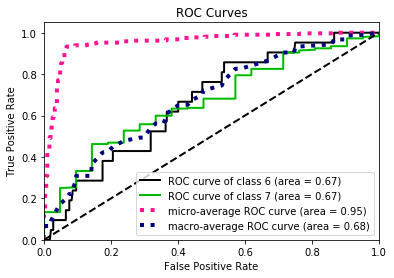

In [91]:
import sklearn
import scikitplot as skplt
import matplotlib.pyplot as plt
from sklearn.calibration import CalibratedClassifierCV
samplesize = int(0.8*X.shape[0])
X_train = X[:samplesize,:]
y_train = y[:samplesize]   
X_test = X[samplesize:, :]
y_test = y[samplesize:] 
clf = CalibratedClassifierCV(libsvm_clf) 
clf.fit(X_train, y_train)
y_pred_prob = clf.predict_proba(X_test)
y_pred = clf.predict(X_test)
skplt.metrics.plot_roc(y_test, y_pred_prob)
plt.show()